## Imports and Device Setup

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Loading and Preprocessing

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


## Plot some smaple images from dataset

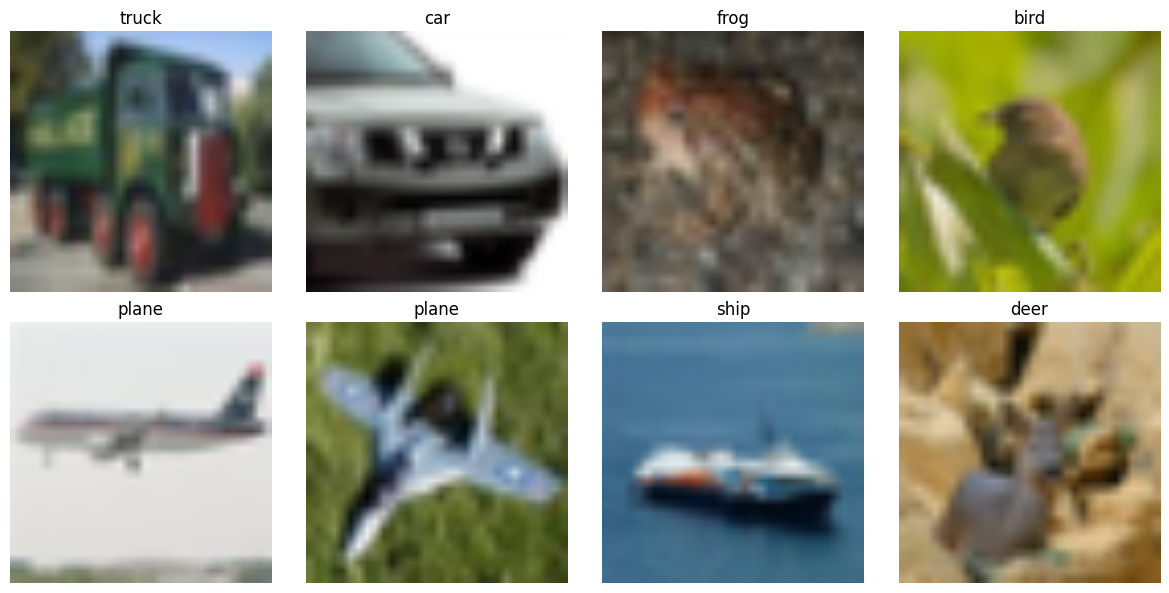

In [3]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.figure(figsize=(12, 6))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    imshow(images[i])
    plt.title(classes[labels[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

## Student Model Definition

In [4]:
class StudentCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(StudentCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True),
        )

        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(128 * 56 * 56, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

## Helper Function for Evaluation

In [5]:
def evaluate_model(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
    return accuracy

## Training the Student from Scratch (Baseline)

In [6]:
print("--- Task 1: Training Student from Scratch ---")
student_scratch = StudentCNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(student_scratch.parameters(), lr=0.001)

for epoch in range(5):
    running_loss = 0.0
    student_scratch.train()
    for i, data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/5")):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = student_scratch(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1} Train Loss: {running_loss / len(train_loader):.4f}")
    evaluate_model(student_scratch, test_loader, loss_fn, device)

print('Finished Training Baseline Student')

--- Task 1: Training Student from Scratch ---


Epoch 1/5: 100%|██████████| 1563/1563 [01:57<00:00, 13.31it/s]

Epoch 1 Train Loss: 1.6111


Test Loss: 1.4469, Test Accuracy: 48.36%


Epoch 2/5: 100%|██████████| 1563/1563 [01:54<00:00, 13.70it/s]

Epoch 2 Train Loss: 1.3265


Test Loss: 1.2404, Test Accuracy: 55.25%


Epoch 3/5: 100%|██████████| 1563/1563 [01:55<00:00, 13.54it/s]

Epoch 3 Train Loss: 1.0864


Test Loss: 1.1522, Test Accuracy: 58.84%


Epoch 4/5: 100%|██████████| 1563/1563 [01:55<00:00, 13.56it/s]

Epoch 4 Train Loss: 0.8849


Test Loss: 1.1345, Test Accuracy: 60.69%


Epoch 5/5: 100%|██████████| 1563/1563 [01:55<00:00, 13.57it/s]

Epoch 5 Train Loss: 0.6693


Test Loss: 1.2988, Test Accuracy: 60.11%
Finished Training Baseline Student


## Fine-Tuning the First Teacher (MobileNetV3)

In [7]:
import torchvision.models as models
print("\n--- Fine-tuning of MobileNetV3 Teacher ---")

class MobileNetV3(nn.Module):
    def __init__(self, num_classes=10, num_blocks_to_unfreeze=3):
        super().__init__()

        mobilenet_base = models.mobilenet_v3_large(weights='MobileNet_V3_Large_Weights.DEFAULT')

        self.features = mobilenet_base.features

        for param in self.features.parameters():
            param.requires_grad = False

        for block in self.features[-num_blocks_to_unfreeze:]:
            for param in block.parameters():
                param.requires_grad = True

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(960, 128),
            nn.Hardswish(),
            nn.Dropout(p=0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

mobilenet_v3_teacher = MobileNetV3().to(device)
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, mobilenet_v3_teacher.parameters()),
    lr=1e-4
)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(5):
    mobilenet_v3_teacher.train()
    running_loss = 0.0
    for data in tqdm(train_loader, desc=f"Fine-tuning Epoch {epoch+1}/5"):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = mobilenet_v3_teacher(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1} Fine-tuning Loss: {running_loss / len(train_loader):.4f}")
    evaluate_model(mobilenet_v3_teacher, test_loader, loss_fn, device)

print('Finished Fine-tuning Teacher in a single stage.')

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth



--- Fine-tuning of MobileNetV3 Teacher ---


100%|██████████| 21.1M/21.1M [00:00<00:00, 170MB/s]
Fine-tuning Epoch 1/5: 100%|██████████| 1563/1563 [01:40<00:00, 15.49it/s]

Epoch 1 Fine-tuning Loss: 0.6688


Test Loss: 0.4081, Test Accuracy: 86.28%


Fine-tuning Epoch 2/5: 100%|██████████| 1563/1563 [01:40<00:00, 15.49it/s]

Epoch 2 Fine-tuning Loss: 0.3833


Test Loss: 0.3580, Test Accuracy: 87.43%


Fine-tuning Epoch 3/5: 100%|██████████| 1563/1563 [01:39<00:00, 15.70it/s]

Epoch 3 Fine-tuning Loss: 0.2811


Test Loss: 0.3457, Test Accuracy: 88.27%


Fine-tuning Epoch 4/5: 100%|██████████| 1563/1563 [01:39<00:00, 15.66it/s]

Epoch 4 Fine-tuning Loss: 0.2112


Test Loss: 0.3727, Test Accuracy: 87.53%


Fine-tuning Epoch 5/5: 100%|██████████| 1563/1563 [01:41<00:00, 15.43it/s]

Epoch 5 Fine-tuning Loss: 0.1600


Test Loss: 0.3863, Test Accuracy: 88.34%
Finished Fine-tuning Teacher in a single stage.


## Fine-Tuning the Second Teacher (MobileNetV2)

In [8]:
print("\n--- Task 2, Teacher 2: Fine-tuning MobileNetV2 ---")

class MobileNetV2_Teacher(nn.Module):
    def __init__(self, num_classes=10, num_blocks_to_unfreeze=3):
        super().__init__()

        mobilenet_base = models.mobilenet_v2(weights='MobileNet_V2_Weights.DEFAULT')
        self.features = mobilenet_base.features

        for param in self.features.parameters():
            param.requires_grad = False

        for block in self.features[-num_blocks_to_unfreeze:]:
            for param in block.parameters():
                param.requires_grad = True

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1280, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

mobilenet_v2_teacher = MobileNetV2_Teacher().to(device)
optimizer_2 = optim.Adam(
    filter(lambda p: p.requires_grad, mobilenet_v2_teacher.parameters()),
    lr=1e-4
)
loss_fn_2 = nn.CrossEntropyLoss()
for epoch in range(5):
    mobilenet_v2_teacher.train()
    running_loss = 0.0
    for data in tqdm(train_loader, desc=f"Fine-tuning MobileNetV2 Epoch {epoch+1}/5"):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_2.zero_grad()
        outputs = mobilenet_v2_teacher(inputs)
        loss = loss_fn_2(outputs, labels)
        loss.backward()
        optimizer_2.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1} MobileNetV2 Loss: {running_loss / len(train_loader):.4f}")
    evaluate_model(mobilenet_v2_teacher, test_loader, loss_fn_2, device)

print('Finished fine-tuning MobileNetV2 Teacher.')

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth



--- Task 2, Teacher 2: Fine-tuning MobileNetV2 ---


100%|██████████| 13.6M/13.6M [00:00<00:00, 100MB/s] 
Fine-tuning MobileNetV2 Epoch 1/5: 100%|██████████| 1563/1563 [01:42<00:00, 15.29it/s]

Epoch 1 MobileNetV2 Loss: 0.7563


Test Loss: 0.4632, Test Accuracy: 83.90%


Fine-tuning MobileNetV2 Epoch 2/5: 100%|██████████| 1563/1563 [01:43<00:00, 15.17it/s]

Epoch 2 MobileNetV2 Loss: 0.4614


Test Loss: 0.4114, Test Accuracy: 85.66%


Fine-tuning MobileNetV2 Epoch 3/5: 100%|██████████| 1563/1563 [01:41<00:00, 15.41it/s]

Epoch 3 MobileNetV2 Loss: 0.3643


Test Loss: 0.3841, Test Accuracy: 86.77%


Fine-tuning MobileNetV2 Epoch 4/5: 100%|██████████| 1563/1563 [01:42<00:00, 15.23it/s]

Epoch 4 MobileNetV2 Loss: 0.2948


Test Loss: 0.3750, Test Accuracy: 87.48%


Fine-tuning MobileNetV2 Epoch 5/5: 100%|██████████| 1563/1563 [01:42<00:00, 15.32it/s]

Epoch 5 MobileNetV2 Loss: 0.2416


Test Loss: 0.3771, Test Accuracy: 87.13%
Finished fine-tuning MobileNetV2 Teacher.


## Distilling from a Single Teacher (MobileNetV3)

In [9]:
print("\n--- Task 3: Distilling Knowledge from MobileNetV3 to Student ---")
student_distilled = StudentCNN().to(device)
optimizer_distill = optim.Adam(student_distilled.parameters(), lr=0.001)
student_loss_fn = nn.CrossEntropyLoss()
distillation_loss_fn = nn.KLDivLoss(reduction='batchmean')
alpha = 0.1
temperature = 5.0
mobilenet_v3_teacher.eval()

for epoch in range(5):
    running_loss = 0.0
    student_distilled.train()

    for data in tqdm(train_loader, desc=f"Distillation Epoch {epoch+1}/5"):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_distill.zero_grad()
        student_logits = student_distilled(inputs)
        with torch.no_grad():
            teacher_logits = mobilenet_v3_teacher(inputs)
        hard_loss = student_loss_fn(student_logits, labels)
        soft_loss = distillation_loss_fn(
            F.log_softmax(student_logits / temperature, dim=1),
            F.softmax(teacher_logits / temperature, dim=1)
        ) * (temperature ** 2)
        loss = alpha * hard_loss + (1 - alpha) * soft_loss

        loss.backward()
        optimizer_distill.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1} Combined Distillation Loss: {running_loss / len(train_loader):.4f}")

    evaluate_model(student_distilled, test_loader, student_loss_fn, device)

print('Finished Distilling Knowledge to Student.')


--- Task 3: Distilling Knowledge from MobileNetV3 to Student ---


Distillation Epoch 1/5: 100%|██████████| 1563/1563 [02:22<00:00, 10.97it/s]

Epoch 1 Combined Distillation Loss: 9.7184


Test Loss: 1.5826, Test Accuracy: 56.49%


Distillation Epoch 2/5: 100%|██████████| 1563/1563 [02:22<00:00, 10.98it/s]

Epoch 2 Combined Distillation Loss: 6.9208


Test Loss: 1.4241, Test Accuracy: 61.29%


Distillation Epoch 3/5: 100%|██████████| 1563/1563 [02:21<00:00, 11.02it/s]

Epoch 3 Combined Distillation Loss: 5.4896


Test Loss: 1.3637, Test Accuracy: 64.20%


Distillation Epoch 4/5: 100%|██████████| 1563/1563 [02:22<00:00, 10.98it/s]

Epoch 4 Combined Distillation Loss: 4.3331


Test Loss: 1.3417, Test Accuracy: 65.62%


Distillation Epoch 5/5: 100%|██████████| 1563/1563 [02:22<00:00, 10.96it/s]

Epoch 5 Combined Distillation Loss: 3.3213


Test Loss: 1.4368, Test Accuracy: 65.78%
Finished Distilling Knowledge to Student.


## Distilling from an Ensemble of Teachers

In [10]:
print("\n--- Task 4: Distilling from an Ensemble of Teachers to a Student ---")
student_ensemble = StudentCNN().to(device)
optimizer_ensemble = optim.Adam(student_ensemble.parameters(), lr=0.001)
student_loss_fn = nn.CrossEntropyLoss()
distillation_loss_fn = nn.KLDivLoss(reduction='batchmean')
alpha = 0.1
temperature = 5.0
mobilenet_v3_teacher.eval()
mobilenet_v2_teacher.eval()

for epoch in range(5):
    running_loss = 0.0
    student_ensemble.train()

    for data in tqdm(train_loader, desc=f"Ensemble Distill Epoch {epoch+1}/5"):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_ensemble.zero_grad()
        student_logits = student_ensemble(inputs)

        with torch.no_grad():
            teacher_1_logits = mobilenet_v3_teacher(inputs)
            teacher_2_logits = mobilenet_v2_teacher(inputs)
            ensemble_teacher_logits = (teacher_1_logits + teacher_2_logits) / 2.0
        hard_loss = student_loss_fn(student_logits, labels)

        soft_loss = distillation_loss_fn(
            F.log_softmax(student_logits / temperature, dim=1),
            F.softmax(ensemble_teacher_logits / temperature, dim=1)
        ) * (temperature ** 2)

        loss = alpha * hard_loss + (1 - alpha) * soft_loss

        loss.backward()
        optimizer_ensemble.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1} Ensemble Distillation Loss: {running_loss / len(train_loader):.4f}")

    evaluate_model(student_ensemble, test_loader, student_loss_fn, device)

print('Finished Ensemble Distillation.')


--- Task 4: Distilling from an Ensemble of Teachers to a Student ---


Ensemble Distill Epoch 1/5: 100%|██████████| 1563/1563 [03:04<00:00,  8.47it/s]

Epoch 1 Ensemble Distillation Loss: 7.3995


Test Loss: 1.5791, Test Accuracy: 55.65%


Ensemble Distill Epoch 2/5: 100%|██████████| 1563/1563 [03:04<00:00,  8.46it/s]

Epoch 2 Ensemble Distillation Loss: 5.1210


Test Loss: 1.3170, Test Accuracy: 62.71%


Ensemble Distill Epoch 3/5: 100%|██████████| 1563/1563 [03:04<00:00,  8.47it/s]

Epoch 3 Ensemble Distillation Loss: 4.0254


Test Loss: 1.2305, Test Accuracy: 65.35%


Ensemble Distill Epoch 4/5: 100%|██████████| 1563/1563 [03:04<00:00,  8.47it/s]

Epoch 4 Ensemble Distillation Loss: 3.2235


Test Loss: 1.1527, Test Accuracy: 68.15%


Ensemble Distill Epoch 5/5: 100%|██████████| 1563/1563 [03:04<00:00,  8.47it/s]

Epoch 5 Ensemble Distillation Loss: 2.5466


Test Loss: 1.1584, Test Accuracy: 68.20%
Finished Ensemble Distillation.


## Additional Experiment - Sequential Distillation

In [11]:
print("\n--- Sequential Distillation Experiment ---")
student_sequential = StudentCNN().to(device)
alpha = 0.1
temperature = 5.0
print("\n--- Stage 1: Distilling from MobileNet3 Teacher ---")
optimizer_seq_1 = optim.Adam(student_sequential.parameters(), lr=0.001)
mobilenet_v3_teacher.eval()

for epoch in range(5):
    student_sequential.train()
    running_loss = 0.0
    for data in tqdm(train_loader, desc=f"Sequential Stage 1 - Epoch {epoch+1}/5"):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_seq_1.zero_grad()
        student_logits = student_sequential(inputs)
        with torch.no_grad():
            teacher_logits = mobilenet_v3_teacher(inputs)

        hard_loss = nn.CrossEntropyLoss()(student_logits, labels)
        soft_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(student_logits / temperature, dim=1),
            F.softmax(teacher_logits / temperature, dim=1)
        ) * (temperature ** 2)

        loss = alpha * hard_loss + (1 - alpha) * soft_loss
        loss.backward()
        optimizer_seq_1.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1} Loss (Teacher 1): {running_loss / len(train_loader):.4f}")
    evaluate_model(student_sequential, test_loader, nn.CrossEntropyLoss(), device)

print("Finished Stage 1. Student has learned from MobileNetV2.")

print("\n--- Stage 2: Continuing Distillation with MobileNetV2 Teacher ---")
optimizer_seq_2 = optim.Adam(student_sequential.parameters(), lr=0.001)
mobilenet_v2_teacher.eval()

for epoch in range(5):
    student_sequential.train()
    running_loss = 0.0
    for data in tqdm(train_loader, desc=f"Sequential Stage 2 - Epoch {epoch+1}/5"):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_seq_2.zero_grad()
        student_logits = student_sequential(inputs)
        with torch.no_grad():
            teacher_logits = mobilenet_v2_teacher(inputs)

        hard_loss = nn.CrossEntropyLoss()(student_logits, labels)
        soft_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(student_logits / temperature, dim=1),
            F.softmax(teacher_logits / temperature, dim=1)
        ) * (temperature ** 2)

        loss = alpha * hard_loss + (1 - alpha) * soft_loss
        loss.backward()
        optimizer_seq_2.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1} Loss (Teacher 2): {running_loss / len(train_loader):.4f}")
    evaluate_model(student_sequential, test_loader, nn.CrossEntropyLoss(), device)

print("Finished Stage 2. Sequential distillation is complete.")


--- Sequential Distillation Experiment ---

--- Stage 1: Distilling from MobileNet3 Teacher ---


Sequential Stage 1 - Epoch 1/5: 100%|██████████| 1563/1563 [02:23<00:00, 10.89it/s]

Epoch 1 Loss (Teacher 1): 9.6928


Test Loss: 1.9060, Test Accuracy: 52.29%


Sequential Stage 1 - Epoch 2/5: 100%|██████████| 1563/1563 [02:23<00:00, 10.92it/s]

Epoch 2 Loss (Teacher 1): 7.2866


Test Loss: 1.3949, Test Accuracy: 61.02%


Sequential Stage 1 - Epoch 3/5: 100%|██████████| 1563/1563 [02:22<00:00, 10.96it/s]

Epoch 3 Loss (Teacher 1): 5.7263


Test Loss: 1.4228, Test Accuracy: 62.08%


Sequential Stage 1 - Epoch 4/5: 100%|██████████| 1563/1563 [02:22<00:00, 11.00it/s]

Epoch 4 Loss (Teacher 1): 4.4778


Test Loss: 1.5744, Test Accuracy: 63.80%


Sequential Stage 1 - Epoch 5/5: 100%|██████████| 1563/1563 [02:22<00:00, 10.97it/s]

Epoch 5 Loss (Teacher 1): 3.3528


Test Loss: 1.5512, Test Accuracy: 63.26%
Finished Stage 1. Student has learned from MobileNetV2.

--- Stage 2: Continuing Distillation with MobileNetV2 Teacher ---


Sequential Stage 2 - Epoch 1/5: 100%|██████████| 1563/1563 [02:32<00:00, 10.24it/s]

Epoch 1 Loss (Teacher 2): 2.2573


Test Loss: 1.2147, Test Accuracy: 64.62%


Sequential Stage 2 - Epoch 2/5: 100%|██████████| 1563/1563 [02:32<00:00, 10.26it/s]

Epoch 2 Loss (Teacher 2): 1.5638


Test Loss: 1.2339, Test Accuracy: 64.52%


Sequential Stage 2 - Epoch 3/5: 100%|██████████| 1563/1563 [02:32<00:00, 10.23it/s]

Epoch 3 Loss (Teacher 2): 1.1556


Test Loss: 1.2084, Test Accuracy: 64.84%


Sequential Stage 2 - Epoch 4/5: 100%|██████████| 1563/1563 [02:33<00:00, 10.21it/s]

Epoch 4 Loss (Teacher 2): 0.9088


Test Loss: 1.2802, Test Accuracy: 63.95%


Sequential Stage 2 - Epoch 5/5: 100%|██████████| 1563/1563 [02:32<00:00, 10.23it/s]

Epoch 5 Loss (Teacher 2): 0.7789


Test Loss: 1.2554, Test Accuracy: 63.58%
Finished Stage 2. Sequential distillation is complete.


--- Final Evaluation of All Models ---

Evaluating Student (Scratch):
Test Loss: 1.2988, Test Accuracy: 60.11%

Evaluating Teacher (MobileNetV3):
Test Loss: 0.3863, Test Accuracy: 88.34%

Evaluating Teacher (MobileNetV2):
Test Loss: 0.3771, Test Accuracy: 87.13%

Evaluating Student (Distilled from Single Teacher):
Test Loss: 1.4368, Test Accuracy: 65.78%

Evaluating Student (Distilled from Ensemble):
Test Loss: 1.1584, Test Accuracy: 68.20%

Evaluating Student (Distilled Sequentially):
Test Loss: 1.2554, Test Accuracy: 63.58%


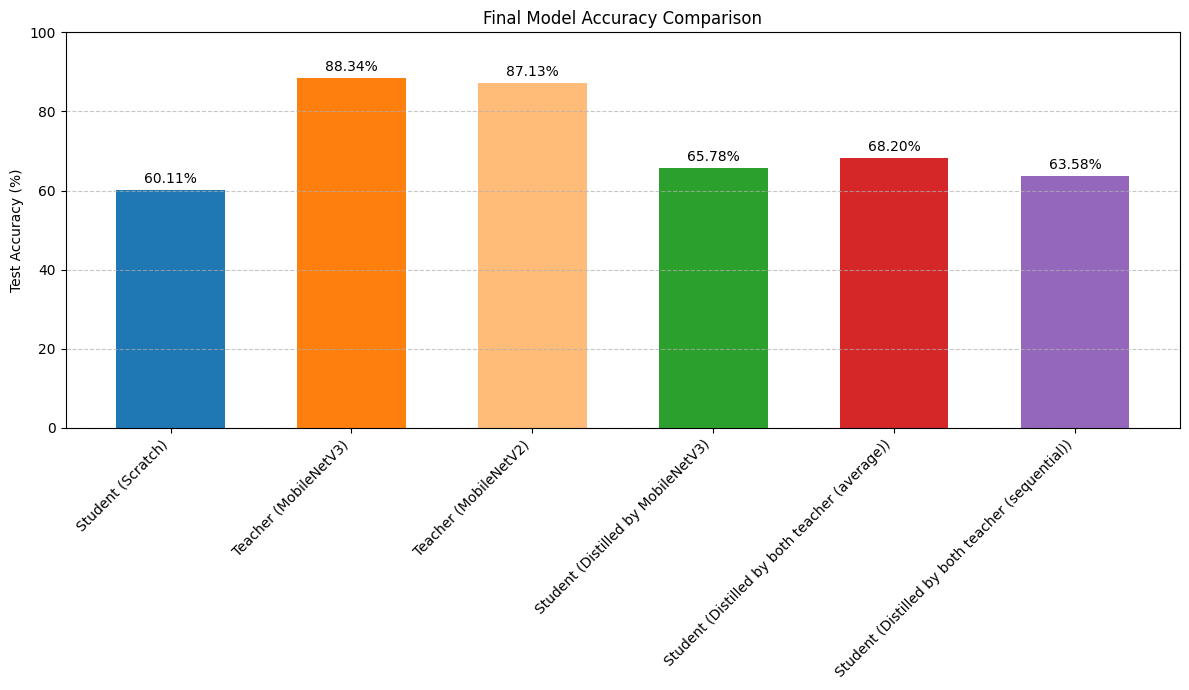

In [12]:
results = {}
print("--- Final Evaluation of All Models ---")
loss_fn_eval = nn.CrossEntropyLoss()

print("\nEvaluating Student (Scratch):")
results['Student (Scratch)'] = evaluate_model(student_scratch, test_loader, loss_fn_eval, device)

print("\nEvaluating Teacher (MobileNetV3):")
results['Teacher (MobileNetV3)'] = evaluate_model(mobilenet_v3_teacher, test_loader, loss_fn_eval, device)

print("\nEvaluating Teacher (MobileNetV2):")
results['Teacher (MobileNetV2)'] = evaluate_model(mobilenet_v2_teacher, test_loader, loss_fn_eval, device)

print("\nEvaluating Student (Distilled from Single Teacher):")
results['Student (Distilled by MobileNetV3)'] = evaluate_model(student_distilled, test_loader, loss_fn_eval, device)

print("\nEvaluating Student (Distilled from Ensemble):")
results['Student (Distilled by both teacher (average))'] = evaluate_model(student_ensemble, test_loader, loss_fn_eval, device)

print("\nEvaluating Student (Distilled Sequentially):")
results['Student (Distilled by both teacher (sequential))'] = evaluate_model(student_sequential, test_loader, loss_fn_eval, device)

labels = [
    'Student (Scratch)',
    'Teacher (MobileNetV3)',
    'Teacher (MobileNetV2)',
    'Student (Distilled by MobileNetV3)',
    'Student (Distilled by both teacher (average))',
    'Student (Distilled by both teacher (sequential))'
]

accuracies = [results[label] for label in labels]

colors = [
    '#1f77b4',  # Student Baseline
    '#ff7f0e',  # Teacher 1
    '#ffbb78',  # Teacher 2
    '#2ca02c',  # Distilled Student (Single)
    '#d62728',  # Distilled Student (Ensemble) - The Best one
    '#9467bd'   # Distilled Student (Sequential)
]

x = np.arange(len(labels))
width = 0.6

fig, ax = plt.subplots(figsize=(12, 7))
rects = ax.bar(x, accuracies, width, label='Accuracy', color=colors)

# Add some text for labels, title and axes ticks
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('Final Model Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_ylim(0, 100)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add accuracy labels on top of the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10)

autolabel(rects)
fig.tight_layout()
plt.show()